# Initial Block

In [1]:
import os
import glob
import time
import joblib
from getpass import getpass
from google.colab import drive





drive.mount('/content/drive', force_remount=True)
os.chdir("/content/drive/My Drive/coco_segment/")

print("DO NOT LEAVE ./coco_segment  directory")
print("Switched to ",os.getcwd())


########################
### switch directory ###
########################

def switch_directory(ip=None, getPath=False, verbose=False):
  d = {}

  l = [
      "/content/drive/My Drive/coco_segment/", #0
      "/content/drive/My Drive/coco_segment/coco_seg/", #1
      "/content/drive/My Drive/coco_segment/coco_seg/picklefiles/", #2
      "/content/drive/My Drive/coco_segment/coco_seg/picklefiles/1CH_train_masks/", #3
      "/content/drive/My Drive/coco_segment/coco_seg/picklefiles/1CH_val_masks/", #4
      "/content/drive/My Drive/coco_segment/data/coco/annotations/instances_train2017.json", #5
      "/content/drive/My Drive/coco_segment/data/coco/annotations/instances_val2017.json", #6
  ]

  for x,i in enumerate(l):
      d[x] = i
      if verbose:
        print(x, i)
  
  d["root"] = "/content/drive/My Drive/"
  
  
  if getPath:
    return d[ip]
  
  
  if ip == None:
    
    # print(d)

    ip = int(input("Enter path number "))
    os.chdir(d[ip])
  
  else:
    os.chdir(d[ip])  
    
  
  print("Switched to: ", os.getcwd())
  
  return os.getcwd()

switch_directory(1)




########################
###### LIBRARES ########
########################

from __future__ import absolute_import, division, print_function, unicode_literals

# Install TensorFlow
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass


import tensorflow as tf
import pandas as pd
import numpy as np
import json
from datetime import datetime


import matplotlib.pyplot as plt

from skimage import io
from skimage.transform import rescale, resize, downscale_local_mean, rotate
from glob import glob
from datetime import datetime


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPool2D, MaxPooling2D, UpSampling2D, Conv2DTranspose
from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import concatenate
from tensorflow.keras import backend as K
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import *

print("Tensorflow version ",tf.__version__)

switch_directory(1)
from loadData import CocoHelper, LoadBin





########################
### Custom Libraries ###
########################


dataDir = "../data/coco/"

# (dataDir='../data/coco/', dataType=['train2017', 'val2017'])
co_ob = CocoHelper(dataDir)
ld_bin_ob = LoadBin()


coco1, coco2 = co_ob.coco1, co_ob.coco2  # train, val objects of coco
cc1 = co_ob.coco1['loaded_annFile']
cc2 = co_ob.coco2['loaded_annFile']  # train, val loaded annotations



Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive
DO NOT LEAVE ./coco_segment  directory
Switched to  /content/drive/My Drive/coco_segment
Switched to:  /content/drive/My Drive/coco_segment/coco_seg
TensorFlow 2.x selected.
Tensorflow version  2.0.0
Switched to:  /content/drive/My Drive/coco_segment/coco_seg
loading annotations into memory...
Done (t=19.23s)
creating index...
index created!

loading annotations into memory...
Done (t=2.46s)
creating index...
index created!



# Utilities

General Methods

In [0]:
########################################
######### READ JSON FILE ###############
########################################

def read_json(path):
  """
  Read json file
  
  args: 
    path: path to required file
  returns:
    dict
  """
  with open(path,"r") as json_file:
    d = json.load(json_file)
    
    print(d.keys())
    return d
  
  
########################################
######### GET TRAIN VAL DF #############
########################################
def get_reqd_train_val_df(img_path_df, category_name, cat_id=None):
  
  pattern1 = "./picklefiles/train_dataframes/train_"+category_name+"_df.*"  
  pattern2 = "./picklefiles/val_dataframes/val_"+category_name+"_df.*"  
  
  for i in glob(pattern1):
    p1 = i
  
  for i in glob(pattern2):
    p2 = i
  
  print(p1)
  print(p2)
  
  train_df = joblib.load(p1)
  val_df = joblib.load(p2)
  
  ctrain_df = pd.merge(train_df,img_path_df,on="id", how="left")
  ctrain_df = ctrain_df.drop(columns=['license','date_captured'])

  cval_df = pd.merge(val_df, img_path_df, on="id", how="left", )
  cval_df = cval_df.drop(columns=['license','date_captured'])
  return (ctrain_df, cval_df)

########################################
######### PROC IMG MASK ################
########################################
def resize_image(a,newshape, is_mask=False):
  if is_mask:
    newshape_mask = (newshape[0],newshape[1],1)
    return resize(a,output_shape=newshape_mask)
  else:
    return resize(a,output_shape=newshape)

def to_float(a):
  return np.float32(a)


def preprocess_nn(a,newshape, is_mask=False):
  a = to_float(a)
  a = resize_image(a,newshape,is_mask)
  
  return a

def reshape_fit(a):
  a = np.array([a])
  return a

########################################
######### LOAD IMG MASK ################
########################################

def load_image_mask_online(coco, co_ob, img_id, cat_id, img_path_df, master_df, newshape=(256,256,3)):
  t = img_path_df[img_path_df['id'] == img_id]
  
  req_url = t['coco_url'].values[0]
  # print(req_url)
  
  
  img = io.imread(req_url)
  mask = co_ob.get_mask_of_image(coco, img_id, cat_id=cat_id, img_path_df=img_path_df, master_df=master_df)
  
  img = preprocess_nn(img, newshape)
  mask = preprocess_nn(mask, newshape, is_mask=True)
  
  return (img,mask)

  
########################################
######### PLOT IMG MASK ################
########################################
  
def plot_img_and_mask(img,mask):
  """
  Visualise image and it's mask
  args:
    img: image (numpy array)
    mask: reqd mask of image (numpy array)
  returns:
    matplotlib plot of img and mask
  """

  I = img

  f, ax = plt.subplots(1, 2)
  ax[0].imshow((I).astype(np.int32))
  ax[1].imshow(np.uint8(np.squeeze(mask)*255))
  
  plt.plot()
  plt.show()

  
########################################
######### TIMER METHOD  ################
########################################
  
def timer(start,end):
  hours, rem = divmod(end-start, 3600)
  minutes, seconds = divmod(rem, 60)
  print("{:0>2}:{:0>2}:{:05.2f}".format(int(hours),int(minutes),seconds))
  
  
  

########################################
###### HELPER STEP TRAIN METHOD  #######
########################################
  
def load_params_prev_run(params, step_size=None, set_next=False, verbose=False):
  
  lgs = glob(pathname="/content/drive/My Drive/coco_segment/coco_seg/logs/runs/*.lg")
  lgs.sort(key=os.path.getmtime)
  
  try:
    print("Loading past run info: ",lgs[-1])
    lg_keeper_dict = joblib.load(lgs[-1])
  except Exception as e:
    print("This might be 1st run")
    print("No file found Path erorr")
    return params
  
  
  for i,j in enumerate(lg_keeper_dict.keys()):
    if verbose:
      print()
      print(j," ",params[i],"<-",log_keeper_dict[j])
    params[i]=lg_keeper_dict[j]
  
  print()
  
  if set_next:
    """
    This needs to be done
    start_ix_train = end_ix_train
    end_ix_train += step_size
    
    start_ix_train is params[2]
    end_ix_train is param[3]
    
    similarly for start and end val_ix
    param[4], param[5] resp
    """
    
    
    params[2] = params[3]
    params[3] += step_size
    
    
    # this line will create errors 
    # when val dataset is smaller than 
    # train dataset
    # val set will exhaust
    params[4] = params[5]
    params[5] += step_size
  return params


# Load files

In [3]:
s = time.time()


c = joblib.load("./picklefiles/DICT")
rc = joblib.load("./picklefiles/REVERSE_DICT")

# dataframes
img_path_df = joblib.load("./picklefiles/img_df_anno_all") # must contain path("local") and coco_url

train_master_df = joblib.load("./picklefiles/train_master_df")
val_master_df = joblib.load("./picklefiles/val_master_df")


# loading annotations

# cc1 = joblib.load("./picklefiles/cc_train")
# cc2 = joblib.load("./picklefiles/cc_val")


# ann_train = joblib.load("./picklefiles/train_annotations.bin")
# ann_val = joblib.load("./picklefiles/val_annotations.bin")

# ann_train = read_json(switch_directory(5,getPath=True))
# ann_val = read_json(switch_directory(6,getPath=True))


e = time.time()
print("Time required to load binaries: ", e-s, "seconds")


# print("Remove Docstrings to execute")




# img_path_dataframe
# Loads Training and Validation dataframe which has links to images and image ids.

r_df_train, r_df_val = get_reqd_train_val_df(img_path_df,"person")
r_df_train.head()

Time required to load binaries:  3.937525987625122 seconds
./picklefiles/train_dataframes/train_person_df.1
./picklefiles/val_dataframes/val_person_df.1


id  ...                                         flickr_url
0  214972  ...  http://farm1.staticflickr.com/198/470497699_73...
1  445425  ...  http://farm4.staticflickr.com/3752/8890729709_...
2  222024  ...  http://farm3.staticflickr.com/2392/2193914202_...
3  238712  ...  http://farm6.staticflickr.com/5082/5286320432_...
4  199990  ...  http://farm4.staticflickr.com/3772/9288647540_...

[5 rows x 8 columns]

# Quick Unet

In [0]:
smooth = 1.

def dice(y_true, y_pred):
  y_true_f = K.flatten(y_true)
  y_pred_f = K.flatten(y_pred)
  intersection = K.sum(y_true_f * y_pred_f)
  return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
  return -dice(y_true, y_pred)
  
def iou(y_true, y_pred, smooth=1.):
  intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
  union = K.sum(y_true,-1) + K.sum(y_pred,-1) - intersection
  iou = (intersection + smooth) / ( union + smooth)
  return iou
  
  


def conv_block(
  inputs,

  filters=16,
  kernel_size=(3, 3),
  activation='relu',
  padding='same',
  dropout_rate=0.2,
  dropout=True,
  use_batch_norm=True,

):

  c = Conv2D(filters, kernel_size=kernel_size,
             activation=activation, padding=padding)(inputs)

  if use_batch_norm:
      c = BatchNormalization()(c)

  if dropout > 0.0:
      c = Dropout(dropout_rate)(c)

  c = Conv2D(filters, kernel_size=kernel_size,
             activation=activation, padding=padding)(c)

  if use_batch_norm:
      c = BatchNormalization()(c)

  return c


def transconv_block(
  inputs,

  filters=16,
  kernel_size=(2, 2),
  strides=(2, 2),
  activation='relu',
  padding='same',
):
  ct = Conv2DTranspose(filters, kernel_size, strides=strides,
                       padding=padding, activation=activation)(inputs)

  return ct


def custom_unet(
  depth=4,
  num_classes=1,
  filters=16,
  input_shape=(512, 512, 3),
  activation='relu',
  dropout_rate=0.2,
  learning_rate=1e-4,
  dropout=True,
  use_batch_norm=True,
  verbose=True,):
  """

  """

  inputs = Input(shape=input_shape)
  x = BatchNormalization()(inputs)

  conv_layers = []

  ####################
  #### Downsample ####
  ####################


  for i in range(depth):
      x = conv_block(inputs=x, filters=filters, use_batch_norm=use_batch_norm,
                     dropout=dropout, dropout_rate=dropout_rate)
      conv_layers.append(x)

      x = MaxPooling2D((2,2))(x)

      filters = filters*2


  ####################
  #### Bottleneck ####
  ####################

  x = conv_block(inputs=x, filters=filters, use_batch_norm=use_batch_norm,
                     dropout=dropout, dropout_rate=dropout_rate)


  ####################
  ##### Upsample #####
  ####################

  for i in reversed(conv_layers):
      filters //= 2

      x = transconv_block(x, filters, (2, 2), strides=(2, 2), padding='same')
      x = concatenate([x,i])
      # print(x)
      x = conv_block(inputs=x, filters=filters, use_batch_norm=use_batch_norm,
                     dropout=dropout, dropout_rate=dropout_rate)


  op = Conv2D(num_classes,(1,1),activation='sigmoid')(x)


  model = Model(inputs=[inputs], outputs=[op])
  
  if verbose:
    print(model.summary())

  return model


inputs = Input(shape=(256, 256, 3))
# model = custom_unet(depth=3,verbose=False)

# model.compile(optimizer=Adam(lr=1e-4), loss=dice_coef_loss, metrics=[dice, iou])

# Data Generator

In [5]:
from skimage.transform import rotate
import random
class DataGenerator(tf.keras.utils.Sequence):

  def __init__(self, r_df, cc, co_ob, cat_id, 
         img_path_df, master_df, shuffle=True, batch_size=5, mirror=True, rotater=True):

    'Initialization'

    self.r_df = r_df
    self.bsize = batch_size
    self.cc = cc
    self.co_ob = co_ob
    self.cat_id = cat_id
    self.img_path_df = img_path_df
    self.master_df = master_df
    self.shuffle = shuffle
    self.mirror = mirror
    self.rotater = rotater
    
    self.batch_pointer = 0 
    self.index = r_df.index.values

    self.batch_list = []
    
    
    self.num_train = 0

    ix = list(self.index)
    b_list = []

    for i in range(0,len(ix),batch_size):
      try:
        temp_list = ix[i:i+batch_size]
        b_list.append(temp_list)



      except Exception as e:
        # Last batch 
        temp_list = ix[i:len(ix)]
        b_list.append(temp_list)

        break



    self.batch_list = b_list

    self.curr_batch_imgs = None
    self.curr_batch_mask = None
    
    
    # print(self.batch_list)

    
  def __len__(self):
    'Denotes the number of batches per epoch'
    
    if self.rotater and self.mirror:
      den = self.bsize*2*2
    
    if (self.rotater and self.mirror == False) or (self.rotater == False and self.mirror):
      den = self.bsize*2
    
    if (self.rotater==False and self.mirror == False):
      den = self.bsize
      
    num_batches_per_epoch = int(np.floor(self.index.shape[0]/self.bsize))

    # print("number of batches per epoch {}".format(num_batches_per_epoch))
    
    return num_batches_per_epoch
  
  
  
  
  def get_next_batch_img_ids(self):
    bptr = self.batch_pointer
    bsize = self.bsize 
    
    batch_curr = self.batch_list[bptr]
    # print("\nCurrent Batch ix: ",batch_curr,"\n")
    febi = first_element_of_batch_ix = batch_curr[0]
    lebi = last_element_of_batch_ix = batch_curr[-1]
    
    img_ids = self.r_df.loc[febi:lebi, "id"].values
    
    # print("Dataframe batch index from {} to {}".format(batch_curr[0],batch_curr[-1]))
    # print("Image ID {} to {}".format(img_ids[0],img_ids[-1]))
    
    self.batch_pointer += 1
    
    
    return img_ids

  
  
  
  
  
  
  
  
  def mirror_batch(self, imgs, masks):
    
    ip = len(imgs)
    imgs_, masks_ = [], [] 
    for i,j in zip(imgs,masks):
      imgs_.append(i[:,::-1])
      masks_.append(j[:,::-1])
    
    
    for i,j in zip(imgs_,masks_):
      imgs.append(i)
      masks.append(j)
      
    # print("input {}".format(ip), " mirrored ",len(imgs),"*** mirrored")
    return imgs,masks
  
  
  def rotate_batch(self, imgs, masks):
    
    ip = len(imgs)
    imgs_, masks_ = [], [] 
    for i,j in zip(imgs, masks):
      rn = np.random.randint(-20, 20)
      imgs_.append(rotate(i, angle=rn))
      masks_.append(rotate(j, angle=rn))
    
    for i,j in zip(imgs_,masks_):
      imgs.append(i)
      masks.append(j)
      
    # print("input {}".format(ip), " rotated ",len(imgs),"*** rotated")
    return imgs, masks
  
  
  def __data_generation(self):
    'Generates data containing batch_size samples'

    img_ids = self.get_next_batch_img_ids()
    
    imgs = []
    masks = []
    # print(img_ids)
    
    for i in img_ids:
      r_img, r_mask = load_image_mask_online(self.cc, self.co_ob, i,
                                             self.cat_id, self.img_path_df, self.master_df,
                                             newshape=(256,256,3)
                                            )
      imgs.append(r_img)
      masks.append(r_mask)
    
    
    
    # you can optimise by creating transform function
    # which takes bools mirror and rotater and other params
    # this fn will return imgs, masks
    # do this later
    if self.mirror:
      imgs, masks = self.mirror_batch(imgs,masks)
      # now the list imgs and masks contains both normal and mirrored images
      # print(len(imgs_M))
      
    if self.rotater:
      imgs,masks = self.rotate_batch(imgs,masks)
      # print(len(imgs_R))
      
    if self.shuffle:
      seed_val = np.random.randint(1000,2000)
      random.seed(a=seed_val)
      random.shuffle(imgs)
      random.seed(a=seed_val)
      random.shuffle(masks)

      
    
    # print(len(imgs), len(masks))
    i,m = self.curr_batch_imgs, self.curr_batch_mask = np.array(imgs), np.array(masks)
    
    # print("\n",i.shape,m.shape,"data_generation***\n")
    return (i,m)
    
    
  

  def __getitem__(self, index):
    'Generate one batch of data'
    i, m = self.__data_generation()
    # print(i.shape, m.shape,"get_item***\n")
    self.num_train += i.shape[0]
    return i,m
    
  

  
  """def on_epoch_end(self):
    self.num_train+=len(self.curr_batch_imgs)
  """
  
  
  """
  Write Methods for 
  - shuffling batch
  - rotate image
  - mirror image
  
  and generate data on fly
  
  """
    
  
    
    

""" Tester
r_df = r_df_train 
cc = cc1
cat_id = 1
master_df = train_master_df
batch_size=2


datagen = DataGenerator( r_df, cc, co_ob, cat_id, 
         img_path_df, master_df, batch_size=2)
"""


# datagen.getitem__(0)
0

0

# model_train_val_step()


In [0]:
depth = 3
model = custom_unet(depth=depth, input_shape=(256,256,3), verbose=False)

def model_train_val_step(start_ix_train, end_ix_train,
                         start_ix_val, end_ix_val,
                         
                         cat_id, epochs, 
                         batch_size, 
                         
                         r_df_train, r_df_val,
                         cc1, cc2,
                         
                         callbacks_list,
                         validation_freq = None , # not working 
                         
                         
                         
                         monitor='val_dice',
                         mode='max',
                         
                         model=model,
                         load_latest_model=True,
                         mirror=True, rotater=True,
                         DataGenerator = DataGenerator,
                        ):
  """
  Method for training and vaildation of model
  
  
  Args:
      start_ix_train (int): starting index of r_df_train
      end_ix_train (int): ending index of r_df_train
      start_ix_val (int): starting index of r_df_val
      end_ix_val (int): ending index of r_df_val
      cat_id (int): Category id
      epochs (int): Number of epochs
      batch_size (int): Number of elements in a batch
      r_df_train (pd.DataFrame): required dataframe
      r_df_val (pd.DataFrame): required dataframe
      cc1 (COCO object): loaded Annotations object
      cc2 (COCO object): loaded Annotations object
      callbacks_list (list): list of callbacks for fitting the model
      validation_freq (list): eg [1,10] will run validation on 1st, 10th epoch
      monitor (str, optional): parameter to be monitored
      mode (str, optional): max or min the parameter that is being monitored
      model (tf.keras.model, optional): model
      load_latest_model (bool, optional): load checkpointed model 
  
  
  """
  
  
  
  #Initialize 
  cat_id = cat_id
  epochs = epochs
  batch_size = batch_size
  
  start_ix_train, end_ix_train = start_ix_train, end_ix_train,
  start_ix_val, end_ix_val = start_ix_val, end_ix_val
  
  
  # Trimming dataframe 
  try:
    r_df_train_ = r_df_train.loc[start_ix_train:end_ix_train-1,:]
    r_df_val_ = r_df_val.loc[start_ix_val:end_ix_val-1,:] 
  except Exception as e:
    print("\nCheck starting and ending index of training and validation df\n",e)
  
  
  
  """
  Verbose 
  """
  print("Training Samples {} ".format(r_df_train_.shape[0]))
  print("Validation Samples {} ".format(r_df_val_.shape[0]))
  print("Batch Size {}".format(batch_size))

  
  
  
  """
  Define DataGenerator Objects
  """
  if batch_size>=6:
    mirror=False
    
  training_generator = DataGenerator( 
      r_df_train_, cc1, co_ob, cat_id, 
      img_path_df, train_master_df, True, batch_size, mirror, rotater)
  
  validation_generator = DataGenerator( 
      r_df_val_, cc2, co_ob, cat_id, 
      img_path_df, val_master_df, True, batch_size, mirror, rotater)
  
  
  """
  Write code to load most recent weights that are saved
  """
  if load_latest_model:
    # nm = input("Enter model name: ")  
    sm = glob(pathname="/content/drive/My Drive/coco_segment/coco_seg/logs/models/*.h5")
    sm.sort(key=os.path.getmtime)

    model_to_be_loaded = sm[-1]
    print("Loading weights from {}".format(os.path.basename(model_to_be_loaded)))
    try:
      path = model_to_be_loaded
      model.load_weights(path)
    except Exception as e:
      raise("Enter Valid model name")
  
  
  model.compile(optimizer=Adam(lr=1e-4), loss=dice_coef_loss,
                metrics=[dice, 
                        # iou
                        ]
               )  
  
  """
  Fit generator
  """
  model.fit_generator(
      generator=training_generator,
      validation_data=validation_generator,
      epochs = epochs,
      verbose = 1,
      use_multiprocessing = True,
      # workers=10,
      # shuffle=True,
      callbacks=callbacks_list,
      # validation_freq=validation_freq,
      
      
  )

# Batch Training

## Batch Parameters

In [0]:
"""
See in a batch model is seeing similar images 
i.e mirrored and rotated image
therefore what happens is when one batch is passed
the model will see following 
1. original image
2. rotated(image)
3. mirrored(image)
4. rotated(mirrored(images)) if both mirror and rotater true

lets analyze case 4
by setting batch_size=1 
you are effectively creating 4 variants of same image in a batch

so in batch training model does not see enough variants of training examples
hence it fails to generalise and learn
hence the training dice coefficient is stagnant

so what you can do is in first training round
- train only using mirror augmentation
in next round of training
- train only using rotate augmentation

this will help model generalise and we wont run out of memory

also try using 256,256 images
mirroring is much efficient
use rotating for tuning purpose
"""
start_ix_train, end_ix_train = 0,50
start_ix_val, end_ix_val = 0, 500

cat_id, epochs = 1, 10
batch_size = 5 

r_df_train, r_df_val = r_df_train, r_df_val
cc1, cc2 = cc1, cc2



###################
#### CALLBACKS ####
###################

logdir="./logs/fit/" +datetime.now().strftime("%y%m%d-%H%M%S")
ckptdir="./logs/models/"+datetime.now().strftime("%y%m%d-%H%M%S")+"_"+str(depth)+"U_ep{epoch:02d}-t-{dice:.2f}-v-{val_dice:.2f}.h5"

tb = TensorBoard(log_dir=logdir)
cp = ModelCheckpoint(ckptdir, monitor='val_dice', 
                              verbose=1, save_best_only=True, mode='max') # mode is max
es = EarlyStopping(monitor='val_dice', mode='max', patience=5)
cl = CSVLogger('./logs/csvlogs/training.log.csv', separator=',', append=True)

callbacks_list = [
    tb,
    cp,
    es,
    cl
]

validation_freq = 2


monitor = 'val_dice'
mode = 'max'



model=model
load_latest_model = True
mirror = True
rotater = True





log_keeper_dict = {
    "cat_id":cat_id,
    "epochs":epochs,
    "start_ix_train":start_ix_train,
    "end_ix_train":end_ix_train,
    "start_ix_val":start_ix_val,
    "end_ix_val":end_ix_val,
    "monitor":monitor,
    "validation_freq":validation_freq,
    "mode":mode,
    "load_latest_model":load_latest_model,
    "mirror":mirror,
    "rotater":rotater,
}



## Run Batch Training

In [0]:
"""
start = time.time()

###################
#### TRAIN VAL ####
###################

model_train_val_step(start_ix_train, end_ix_train,
                     start_ix_val, end_ix_val,
                     
                     
                     cat_id, epochs, 
                     
                     batch_size = batch_size, 
                     
                     
                     r_df_train = r_df_train, 
                     r_df_val = r_df_val,
                     
                     cc1=cc1, cc2=cc2,
                     
                     callbacks_list = callbacks_list,
                     validation_freq = validation_freq, # not working 


                     monitor=monitor,
                     mode=mode,

                     model=model,
                     load_latest_model=load_latest_model,
                     
                     mirror=mirror, rotater=rotater,
                     
                     DataGenerator = DataGenerator
                    )


end = time.time()
"""
0

0

# Mini Batch Training

## Mini batch parameters

In [8]:
! nvidia-smi

Sat Nov  9 15:42:55 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 430.50       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    31W / 250W |    361MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
start_ix_train, end_ix_train = 512,640 #set end_ix_train as start_ix_train+step_size
start_ix_val, end_ix_val = 512, 640 #set end_ix_val as start_ix_val+step_size

cat_id, epochs = 1, 5
batch_size = 16 # multiples of 2 

# see that it will lead to number 32, 64, 128
# and it fits in memory

r_df_train, r_df_val = r_df_train, r_df_val
cc1, cc2 = cc1, cc2



###################
#### CALLBACKS ####
###################

logdir="./logs/fit/" +datetime.now().strftime("%y%m%d-%H%M%S")
ckptdir="./logs/models/"+datetime.now().strftime("%y%m%d-%H%M%S")+"_"+str(depth)+"U_ep{epoch:02d}-t-{dice:.2f}-v-{val_dice:.2f}.h5"

tb = TensorBoard(log_dir=logdir)
cp = ModelCheckpoint(ckptdir, monitor='val_dice', 
                              verbose=1, save_best_only=True, mode='max') # mode is max
es = EarlyStopping(monitor='val_dice', mode='max', patience=2)
cl = CSVLogger('./logs/csvlogs/training.log.csv', separator=',', append=True)

callbacks_list = [
    tb,
    cp,
    es,
    cl
]

validation_freq = 2


monitor = 'val_dice'
mode = 'max'



model=model
load_latest_model = True
mirror = True
rotater = True





log_keeper_dict = {
    "cat_id":cat_id,
    "epochs":epochs,
    "start_ix_train":start_ix_train,
    "end_ix_train":end_ix_train,
    "start_ix_val":start_ix_val,
    "end_ix_val":end_ix_val,
    "monitor":monitor,
    "validation_freq":validation_freq,
    "mode":mode,
    "load_latest_model":load_latest_model,
    "mirror":mirror,
    "rotater":rotater,
}


# make it 512 (powers of 2)
total_train_instances = 512
total_val_instances = 512 #<-this may create errors as val set is small
# to solve this repeat val set again and again
# code needs to be written

step_size = 128
steps = int(total_train_instances/step_size)

load_previous_run_info = True

# load parameters from previous run
params = [
  cat_id,
  epochs,
  start_ix_train,
  end_ix_train,
  start_ix_val,
  end_ix_val,
  monitor,
  validation_freq,
  mode,
  load_latest_model,
  mirror,
  rotater,
]
# started at 7.50 pm

## Run Mini Batch Training

In [12]:
! ls -lt ./logs/runs/

total 2
-rw------- 1 root root 254 Nov  8 19:36 19Nov08-193649.lg
-rw------- 1 root root 254 Nov  8 19:32 19Nov08-193235.lg
-rw------- 1 root root 253 Nov  8 19:26 19Nov08-192613.lg
-rw------- 1 root root 252 Nov  8 19:19 19Nov08-191957.lg


In [13]:
start = time.time()
print("total number of steps {}".format(steps))
print(params[3])

while(steps >= 1 and params[3]<=1024):
  params = load_params_prev_run(params, step_size, set_next=True)

  
  print("Resuming training from {} to {}".format(params[2], params[3]))

  # set new logs dict for this run
  for i,j in enumerate(log_keeper_dict.keys()):
    log_keeper_dict[j] = params[i]

  
  joblib.dump(log_keeper_dict, "./logs/runs/" +datetime.now().strftime("%y%b%d-%H%M%S")+".lg")

  lk = log_keeper_dict
  
  model_train_val_step(
                     lk["start_ix_train"], lk["end_ix_train"],
                     lk["start_ix_val"], lk["end_ix_val"],
                     
                     
                     lk["cat_id"], lk["epochs"], 
                     
                     batch_size = batch_size, 
                     
                     
                     r_df_train = r_df_train, 
                     r_df_val = r_df_val,
                     
                     cc1=cc1, cc2=cc2,
                     
                     callbacks_list = callbacks_list,
                     validation_freq = lk["validation_freq"], # not working 


                     monitor= lk["monitor"],
                     mode= lk["mode"],

                     model=model,
                     load_latest_model= lk["load_latest_model"],
                     
                     mirror= lk["mirror"], rotater= lk["rotater"],
                     
                     DataGenerator = DataGenerator
                    )
  
  
  
  steps -=1
end = time.time()

total number of steps 4
640
Loading past run info:  /content/drive/My Drive/coco_segment/coco_seg/logs/runs/19Nov08-193649.lg

Resuming training from 1152 to 1280
Training Samples 128 
Validation Samples 128 
Batch Size 16
Loading weights from 191108-191954_3U_ep04-t-0.49-v-0.47.h5
Epoch 1/5
7/8 [=========================>....] - ETA: 7s - loss: -0.4579 - dice: 0.4579 
Epoch 00001: val_dice improved from -inf to 0.43733, saving model to ./logs/models/191109-154406_3U_ep01-t-0.45-v-0.44.h5
8/8 [==============================] - 121s 15s/step - loss: -0.4479 - dice: 0.4479 - val_loss: -0.4373 - val_dice: 0.4373
Epoch 2/5
7/8 [=========================>....] - ETA: 0s - loss: -0.4799 - dice: 0.4799
Epoch 00002: val_dice did not improve from 0.43733
8/8 [==============================] - 61s 8s/step - loss: -0.4719 - dice: 0.4719 - val_loss: -0.4143 - val_dice: 0.4143
Epoch 3/5
7/8 [=========================>....] - ETA: 0s - loss: -0.4883 - dice: 0.4883
Epoch 00003: val_dice did not impro

In [0]:
timer(start, end)

00:23:17.08


# Checking and Testing

In [0]:

def quick_check(cc, co_ob, id_to_check, cat_id, img_path_df, master_df, mask_pred):
  """
  Plot 
  True Image True Mask
  True Image Pred Mask
  """
  
  actual_img, actual_mask =  load_image_mask_online(cc, co_ob, id_to_check, cat_id, img_path_df, master_df)
  plot_img_and_mask(actual_img,actual_mask)
  
  plot_img_and_mask(actual_img,np.squeeze(mask_pred))


def check_pred_img_for_img_id(model, img_id, cc, co_ob, cat_id, img_path_df, master_df):
  img, mask = load_image_mask_online(cc, co_ob, img_id, cat_id, img_path_df, master_df)
  
  img_ = img.reshape((1, img.shape[0], img.shape[1], img.shape[2]))
  # print(img_.shape)
  mask_pred = model.predict(img_)
  
  quick_check(cc, co_ob, img_id, cat_id, img_path_df, master_df, mask_pred)
  
  return mask_pred

def loop_plot_and_check_pred(model, img_id_list,
                          cc, co_ob, cat_id,
                          img_path_df, master_df):
  
  for i in img_id_list:
    # print(i)
    mask_pred = check_pred_img_for_img_id(model, i, 
                            cc, co_ob, cat_id,
                            img_path_df, master_df)
    


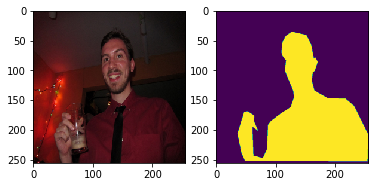

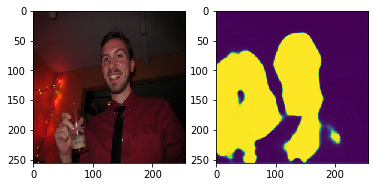

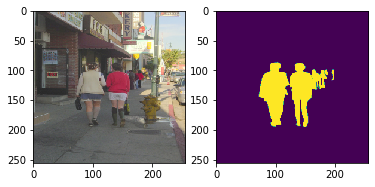

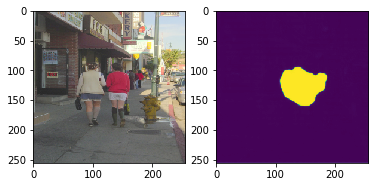

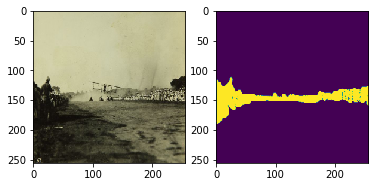

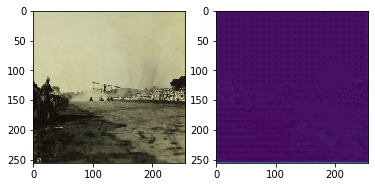

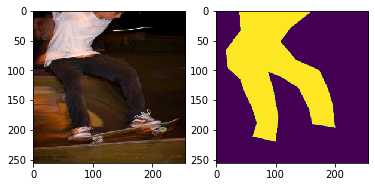

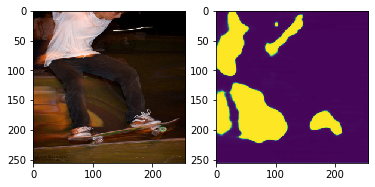

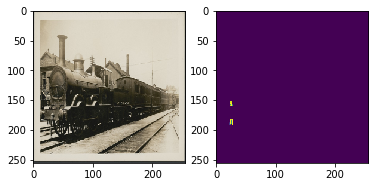

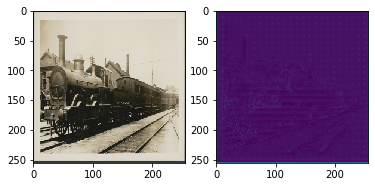

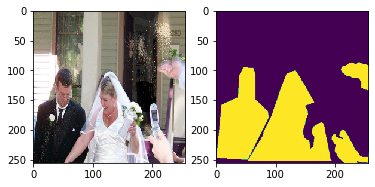

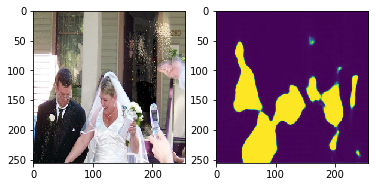

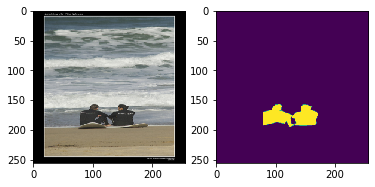

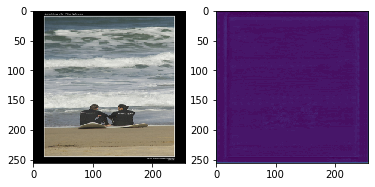

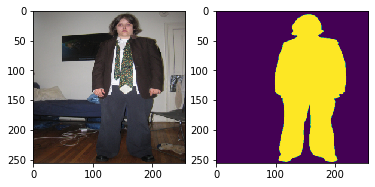

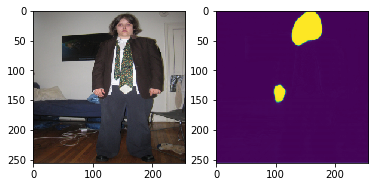

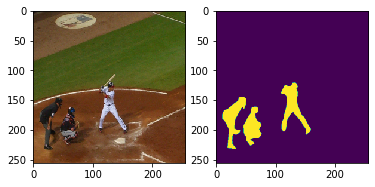

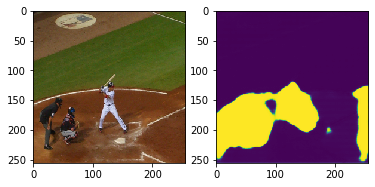

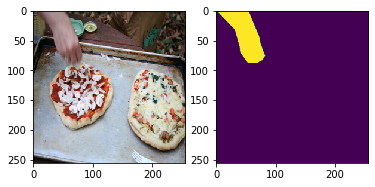

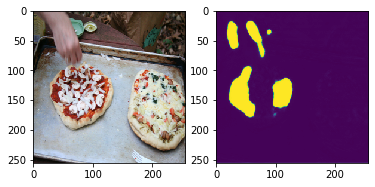

In [15]:
img_ids_list_train = r_df_train.iloc[1152:1162]['id'].values
loop_plot_and_check_pred(model, img_ids_list_train, cc1, co_ob, cat_id, img_path_df, train_master_df)

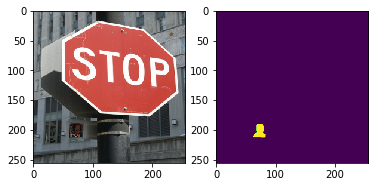

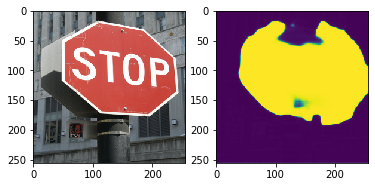

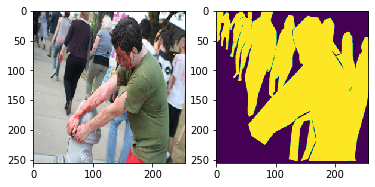

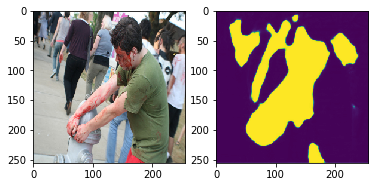

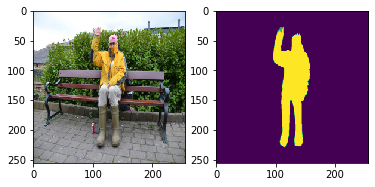

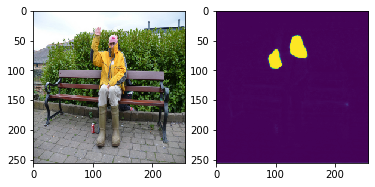

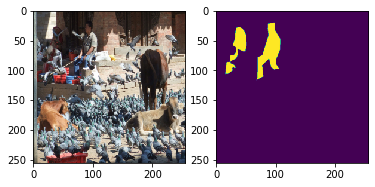

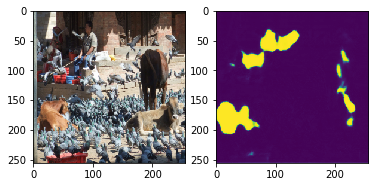

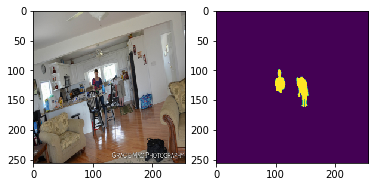

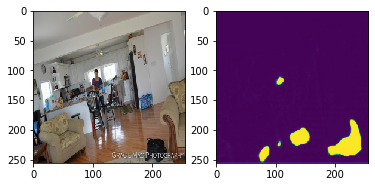

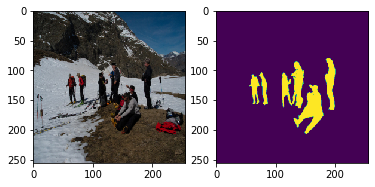

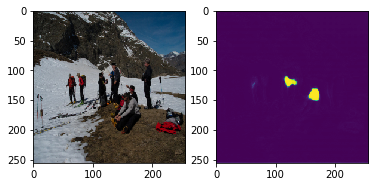

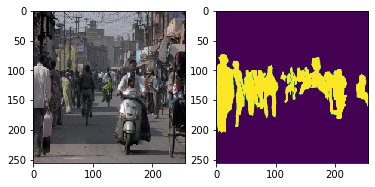

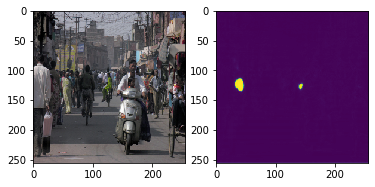

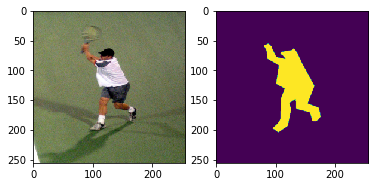

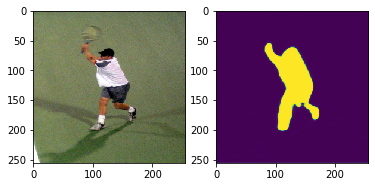

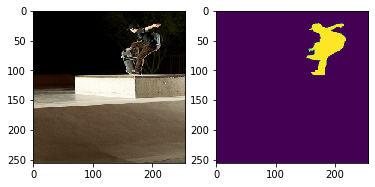

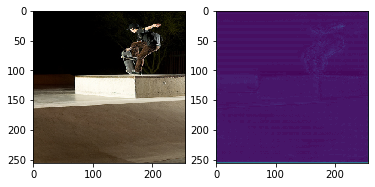

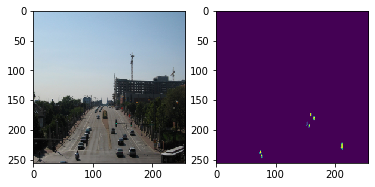

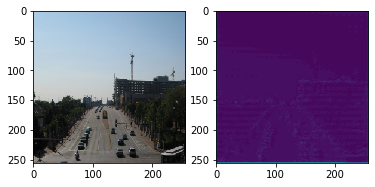

In [16]:

img_ids_list_val = r_df_val.iloc[1152:1162]['id'].values
loop_plot_and_check_pred(model, img_ids_list_val, cc2, co_ob, cat_id, img_path_df, val_master_df)